# I. Prediction

## a) Nettoyage et Chargement de la donnée


Scikit learn possède quelques datasets de tests qui permettent de rapidement tester avec peux d'efforts

Il y a les exemples de jeux et les datasets réels. Dans notre exemple nous allons nous concentrer sur un dataset de jeux


In [2]:
from sklearn.datasets import load_wine
sk_df = load_wine()

En pratique, les dataframes pandas sont plus utilisé (ou numpy) car ils permettent de traiter et nettoyer la donnée avant leur utilisation


In [78]:
import pandas as pd

pdf = pd.read_csv('https://s3.amazonaws.com/rawstore.datahub.io/8be2b68381437d055ee597dc53357ff9.csv')
pdf_target = pdf['class'].apply(lambda x : x.lower() == 'absent')

## b) Mise en place premier apprentissage



### Préparation de la donnée
Nous allons séparer les données en plusieurs groupes afin de s'assurer que notre rochain modèle fonctionne

In [90]:
from sklearn import model_selection

xdata,ydata,xtarget,ytarget = model_selection.train_test_split(sk_df.data,sk_df.target)
pxdata,pydata,pxtarget,pytarget = model_selection.train_test_split(pdf.iloc[:,0:-1],pdf_target)

vérifions tout de même que le random nous donnes des données correctes pour le learning et les tests

In [119]:
pytarget.value_counts()

True     41
False    27
Name: class, dtype: int64

In [120]:
pxtarget.value_counts()

True     109
False     93
Name: class, dtype: int64

### Premier apprentissage avec une simple régression
Retenez qu'il existe d'autre algorithmes

In [193]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear')
plr = LogisticRegression(solver='liblinear')

model = lr.fit(xdata,xtarget)
pmodel = plr.fit(pxdata,pxtarget)


## c) Regardons les résultats 

### avec une simple **matrice de confusion**

In [93]:
from sklearn import metrics
metrics.confusion_matrix(ytarget,model.predict(ydata))

array([[12,  1,  0],
       [ 0, 19,  1],
       [ 0,  1, 11]])

In [94]:
metrics.confusion_matrix(pytarget,pmodel.predict(pydata))

array([[23,  4],
       [ 5, 36]])

En plus jolie

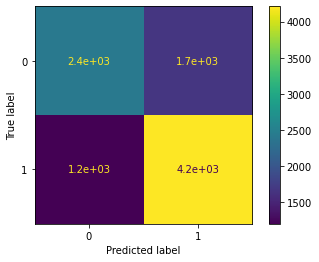

In [195]:
metrics.plot_confusion_matrix(plr,pxdata,pxtarget)

### Puis avec d'autres métriques

In [95]:
print(metrics.f1_score(pytarget,pmodel.predict(pydata)))
metrics.recall_score(pytarget,pmodel.predict(pydata))

0.888888888888889


0.8780487804878049

In [96]:
metrics.accuracy_score(ytarget,model.predict(ydata))

0.9333333333333333

ou même un scorer personnalisé (exemple jouet sans grands intérêt :)

In [97]:
sc = metrics.make_scorer( lambda yp,yt : pd.Series((yt == yp)).astype(int).sum(),greater_is_better=True)
sc(lr,ydata,ytarget)

42

### Soyons plus visuel!

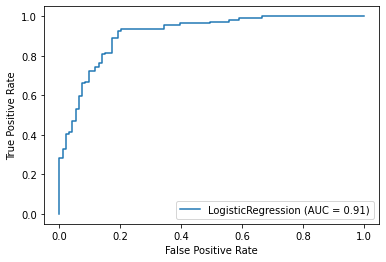

In [98]:
metrics.plot_roc_curve(plr,pxdata,pxtarget)

## d) Optimisons notre model

### toutes les features sont elle vraiment importante?

In [118]:
from sklearn.feature_selection import SelectFromModel

plr = LogisticRegression(solver='liblinear')
sfm = SelectFromModel(plr)
sfm.fit(pxdata,pxtarget)
sfm.get_support()

array([False,  True,  True, False, False, False, False, False,  True,
        True, False,  True, False])

Regardons quelles sont les columnes correspondantes

In [117]:
pdf.iloc[:,sfm.get_support(indices=True)].columns

Index(['sex', 'chest', 'exercise_induced_angina', 'oldpeak',
       'number_of_major_vessels'],
      dtype='object')

### A-t-on vraiment choisit le bon modèle ?

In [122]:
params = [{'solver' : ['newton-cg','liblinear'], 'C' : [1,0.75,0.5]}]
plr = LogisticRegression(solver='liblinear')
model_benchs = model_selection.GridSearchCV(estimator=plr,param_grid=params,scoring='accuracy').fit(pxdata,pxtarget)

#pour l'affichage un dataframe est plus jolie
pd.DataFrame(model_benchs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.040308,0.007445,0.001308,0.000096,1,newton-cg,"{'C': 1, 'solver': 'newton-cg'}",0.658537,0.804878,0.825,0.85,0.850,0.797683,0.071601,4
1,0.002608,0.000247,0.001136,0.000256,1,liblinear,"{'C': 1, 'solver': 'liblinear'}",0.804878,0.780488,0.800,0.85,0.825,0.812073,0.023667,3
2,0.036228,0.004062,0.001259,0.000036,0.75,newton-cg,"{'C': 0.75, 'solver': 'newton-cg'}",0.658537,0.804878,0.825,0.85,0.850,0.797683,0.071601,4
3,0.002230,0.000085,0.000940,0.000025,0.75,liblinear,"{'C': 0.75, 'solver': 'liblinear'}",0.780488,0.780488,0.825,0.85,0.825,0.812195,0.027451,1
4,0.030677,0.004468,0.001222,0.000012,0.5,newton-cg,"{'C': 0.5, 'solver': 'newton-cg'}",0.682927,0.804878,0.825,0.85,0.825,0.797561,0.059077,6
5,0.002218,0.000108,0.000940,0.000055,0.5,liblinear,"{'C': 0.5, 'solver': 'liblinear'}",0.780488,0.780488,0.825,0.85,0.825,0.812195,0.027451,1


# II. Clustering

## Chargement de la donnée
Créons des clusters à la main en random

In [184]:
from sklearn.datasets import make_blobs

features, true_labels = make_blobs(
    n_samples=400,
     centers=4,
     cluster_std=2.0,
     random_state=42
 )


Regardons le résultat

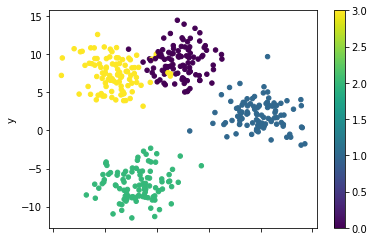

In [186]:
pd.DataFrame(features,columns=['x','y']).plot.scatter(x='x',y='y',c=true_labels,colormap='viridis')

## Mise en place du clustering

Un pipeline sert à ajouter des transformations dans un workflow de traitement de données
(la bonne pratique est l'itulisation de ce pipeline)

In [190]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clustering',KMeans(
            init="random",
            n_clusters=4,
            n_init=15,
            max_iter=300,
            random_state=42
         )
        )
])
pipe.fit(features,true_labels)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clustering',
                 KMeans(algorithm='auto', copy_x=True, init='random',
                        max_iter=300, n_clusters=4, n_init=15, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0))],
         verbose=False)

## Resultats
Observons notre nouvelles sorties

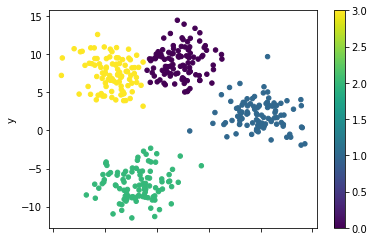

In [191]:
pd.DataFrame(features,columns=['x','y']).plot.scatter(x='x',y='y',c=pipe.predict(features),colormap='viridis')

Exceptionnellement puisque nous avons simuler les clusters, nous pouvons nous amuser à comparer par rapport à notre generateur

In [196]:
metrics.confusion_matrix(true_labels,pipe.predict(features))

array([[ 98,   0,   0,   2],
       [  0, 100,   0,   0],
       [  0,   0, 100,   0],
       [  7,   0,   0,  93]])

# III Regression

## chargement de la donnée

In [202]:
from sklearn.datasets import fetch_california_housing

chp = fetch_california_housing()

regardons les tendances des résultats (les prix)

Et profitons en pour donner un exemples avec seaborn !

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


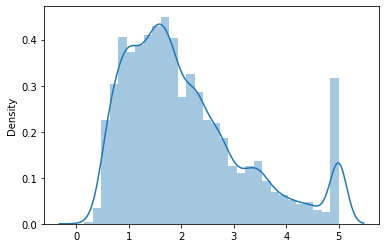

In [203]:
import seaborn as sns
# Attention condainstall seaborn ou pip install seaborn necessaire (sauf sur google colab)
sns.distplot(chp.target, bins=30)

Et sepraons la donnée pour nos tests

In [204]:
rxdata,rydata,rxtarget,rytarget = model_selection.train_test_split(chp.data,chp.target)

## Mise en place des modèles

In [210]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

prices = ElasticNet()
prices2 = RandomForestRegressor()

prices.fit(rxdata,rxtarget)
prices2.fit(rxdata,rxtarget)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## Regardons les résultats

In [211]:
prices.score(rydata,rytarget)

0.41549917993410623

Cela n'est pas très bon car beaucoup trop éloigné de 1, et notre autre solution ?

In [212]:
prices2.score(rxdata,rxtarget)

0.9732444416272611

Les solutions de machine learning ensembliste sont très consommatrice en ressource mais offre de bon résultat avec peu d'optimisation manuelles

De plus le randomforest nous offre la possibiltié de regarder les entrées qui sont le plus utilisé

In [221]:
dict(zip(chp.feature_names,prices2.feature_importances_))

{'AveBedrms': 0.02899484336827611,
 'AveOccup': 0.13556711216981412,
 'AveRooms': 0.03975300350642458,
 'HouseAge': 0.0567637219243821,
 'Latitude': 0.09460127141796632,
 'Longitude': 0.0933201021155374,
 'MedInc': 0.5195141268389354,
 'Population': 0.03148581865866414}

Et en jolie

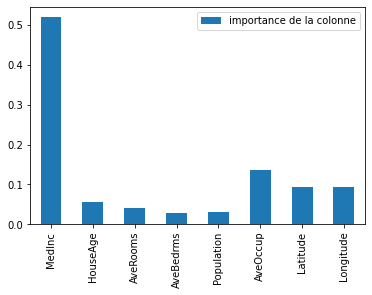

In [266]:
pd.DataFrame(prices2.feature_importances_,index=chp.feature_names,columns=['importance de la colonne']).plot.bar()

# TP ! Maintenant : A vous de jouer


Pouvez vous prédire si un personnes sur le titanic va survivre à plus de 92% ?

In [63]:
df_titanic = pd.read_csv('https://gist.githubusercontent.com/michhar/2dfd2de0d4f8727f873422c5d959fff5/raw/fa71405126017e6a37bea592440b4bee94bf7b9e/titanic.csv')
target_titanic = df_titanic["Survived"]
df.describe(include='all')

------


Un autre dataset pour prendre la main sur scikit learn : prévoir si le client du VTC utilisera le coupon de réduction donnée

Pour un expert, un AUX de 0.81 est posible en 10 lignes (personnellement, je l'ai fait mais en utilisant autre chose que la regressionlogistic)

In [ ]:
df_coupon = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00603/in-vehicle-coupon-recommendation.csv')
target_coupon = df_coupon['Y']